# Лабароторная работа 3. Обучение с учителем. Задача Регрессии.


# Задача регрессии


Загрузка данных.

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('moldova_cars_task.csv')
data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30487 entries, 0 to 30486
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  30487 non-null  object 
 1   Model                 30235 non-null  object 
 2   Year                  30308 non-null  float64
 3   Style                 30441 non-null  object 
 4   Distance              30403 non-null  float64
 5   Engine_capacity(cm3)  30487 non-null  float64
 6   Fuel_type             30487 non-null  object 
 7   Transmission          30321 non-null  object 
 8   Price(euro)           30486 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.1+ MB


Предобработка

Подсчет пустых значений

In [ ]:
#кол во пропущенных значений
data.isna().sum()

Make                      0
Model                   252
Year                    179
Style                    46
Distance                 84
Engine_capacity(cm3)      0
Fuel_type                 0
Transmission            166
Price(euro)               1
dtype: int64

In [ ]:
columns_to_unknown = ['Model'] #в данных столбцах пустые ячейки будут названы unknown
columns_to_median = ['Year', 'Distance'] # в данных столбцах ячейки будут заполнены медианой значений

for row in columns_to_unknown:
    data[row] = data[row].fillna('unknown')

for row in columns_to_median:
  data[row]=data[row].fillna(data[row].median())

data.dropna(subset=['Transmission', 'Style'],inplace=True) # там где нельзя предсказать данные, строки будут удалены

data.isna().sum()

Make                    0
Model                   0
Year                    0
Style                   0
Distance                0
Engine_capacity(cm3)    0
Fuel_type               0
Transmission            0
Price(euro)             0
dtype: int64

Все типы данных установлены верно, поэтому изменять их тип не будем.

**EDA**

In [ ]:
data.head(10)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998.0,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012.0,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
5,Mercedes,Vito,2000.0,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
6,Volkswagen,Passat,2010.0,Universal,290000.0,1390.0,Petrol,Manual,5600.0
7,Volkswagen,Touareg,2010.0,SUV,220000.0,2400.0,Diesel,Automatic,17000.0
8,Mercedes,Series (W124),1991.0,Sedan,240000.0,2300.0,Petrol,Manual,2850.0
9,BMW,5 Series,2004.0,Sedan,325000.0,300.0,Diesel,Manual,3400.0


Составим тепловую карту, чтобы визуализировать корреляцию между признаками в датасете.

<ipython-input-6-d695e6fa3730>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


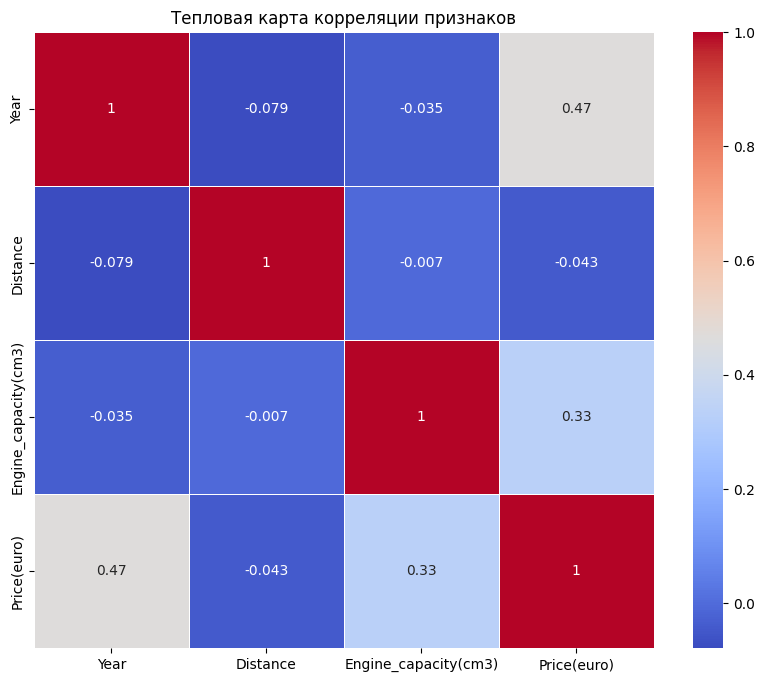

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = data.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Тепловая карта корреляции признаков')
plt.show()


- Year
- Distance
- Engine_capacity(cm3)
- Price(euro)

На эти перечисленные параметры будет обращено особое внимание с помощью гистограмм. Здесь выбросы будут влиять на форму и читаемость гистограмм.

In [ ]:
data.describe()[['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']]

,Year,Distance,Engine_capacity(cm3),Price(euro)
count,30275.000000,3.027500e+04,30275.000000,30275.000000
mean,2008.456647,3.928142e+05,1861.571693,9899.754253
std,8.044707,3.946433e+06,694.204892,10656.069755
min,1900.000000,0.000000e+00,0.000000,1.000000
25%,2005.000000,9.254600e+04,1500.000000,3800.000000
50%,2010.000000,1.690000e+05,1800.000000,7000.000000
75%,2014.000000,2.268440e+05,2000.000000,12700.000000
max,2021.000000,1.000000e+08,9999.000000,490000.000000


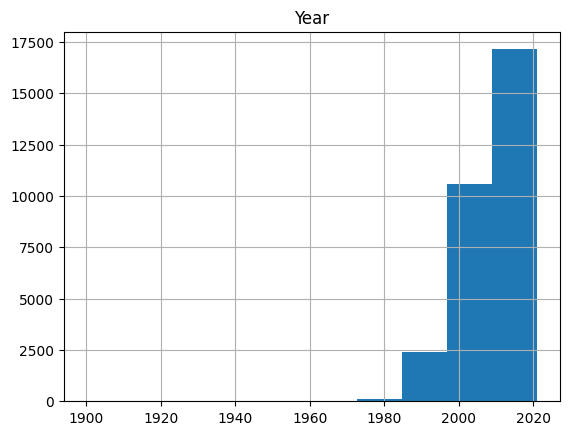

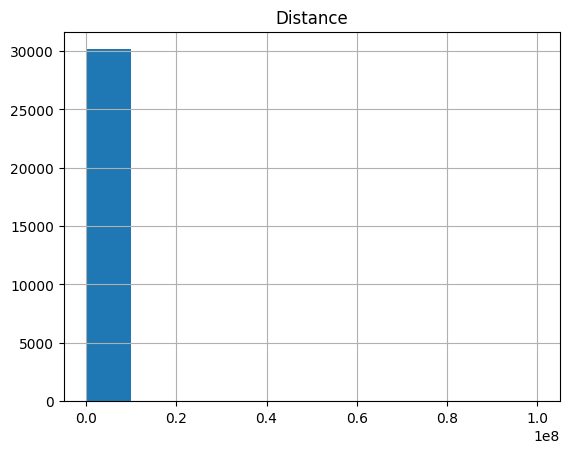

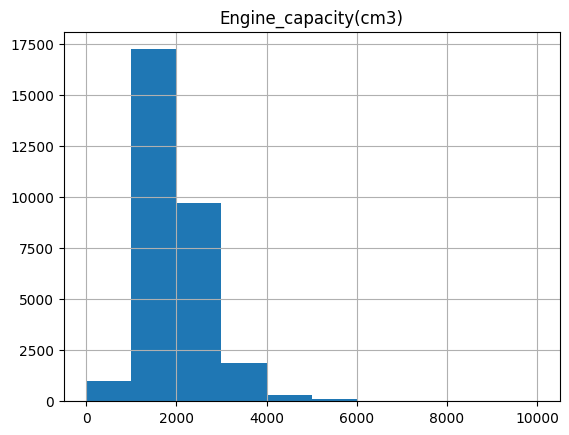

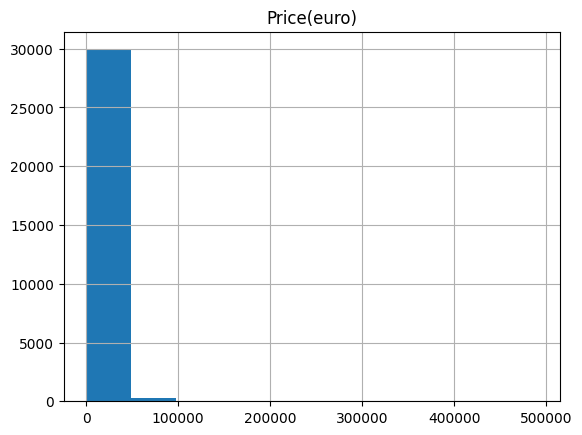

In [ ]:
columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

for column in columns:
    data.hist(column)

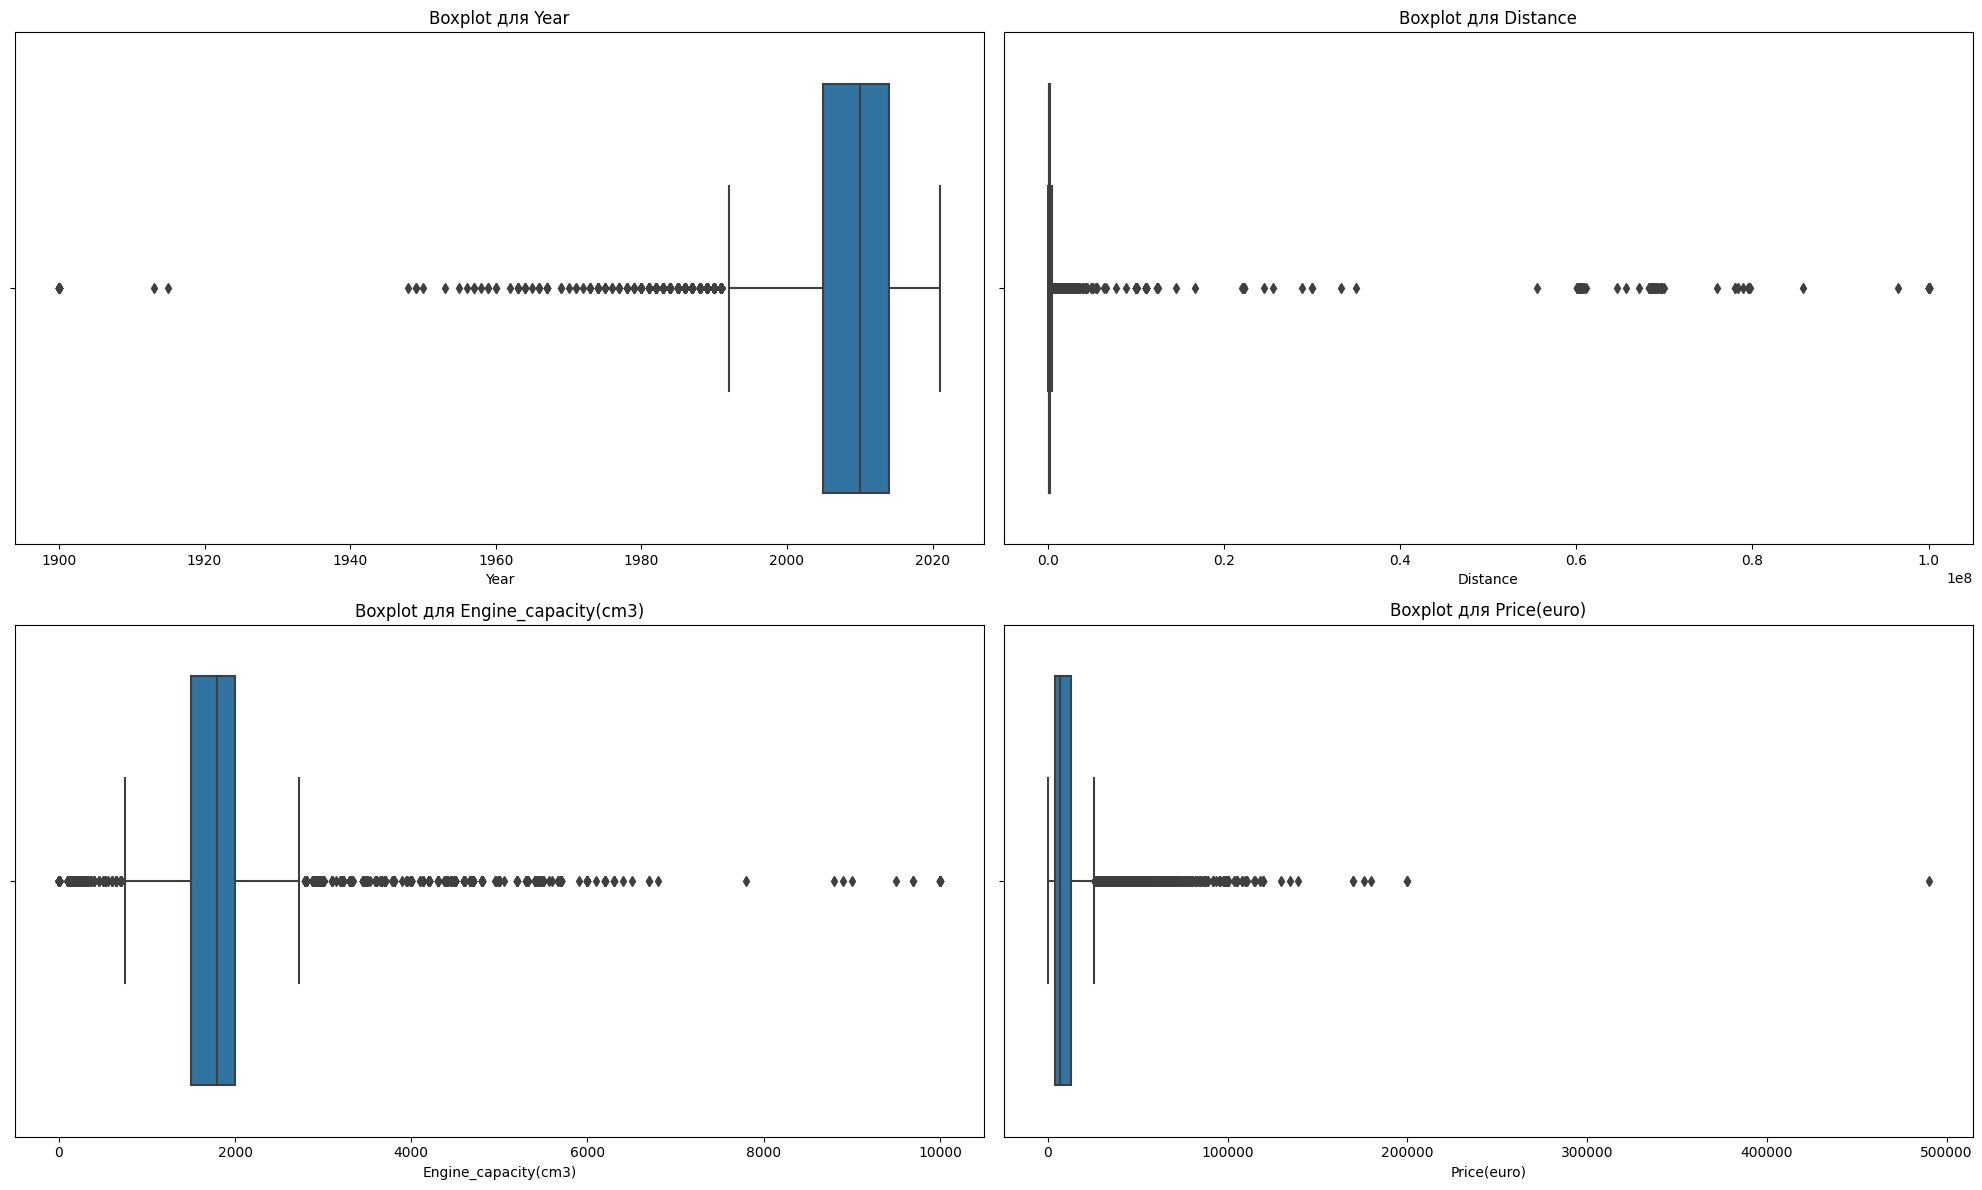

In [ ]:
# Визуализация выбросов с помощью boxplots

plt.figure(figsize=(20, 12))

for idx, col in enumerate(['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)'], start=1):
    plt.subplot(2, 2, idx)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot для {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


Избавимся от выбросов

In [ ]:
# Функция для очистки данных от выбросов на основе IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Очистка данных от выбросов для каждого числового столбца
cleaned_data = data.copy()
for col in ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']:
    cleaned_data = remove_outliers(cleaned_data, col)

# Сравним размеры исходного и очищенного датасетов
original_size = data.shape[0]
cleaned_size = cleaned_data.shape[0]
original_size, cleaned_size


(30275, 24223)

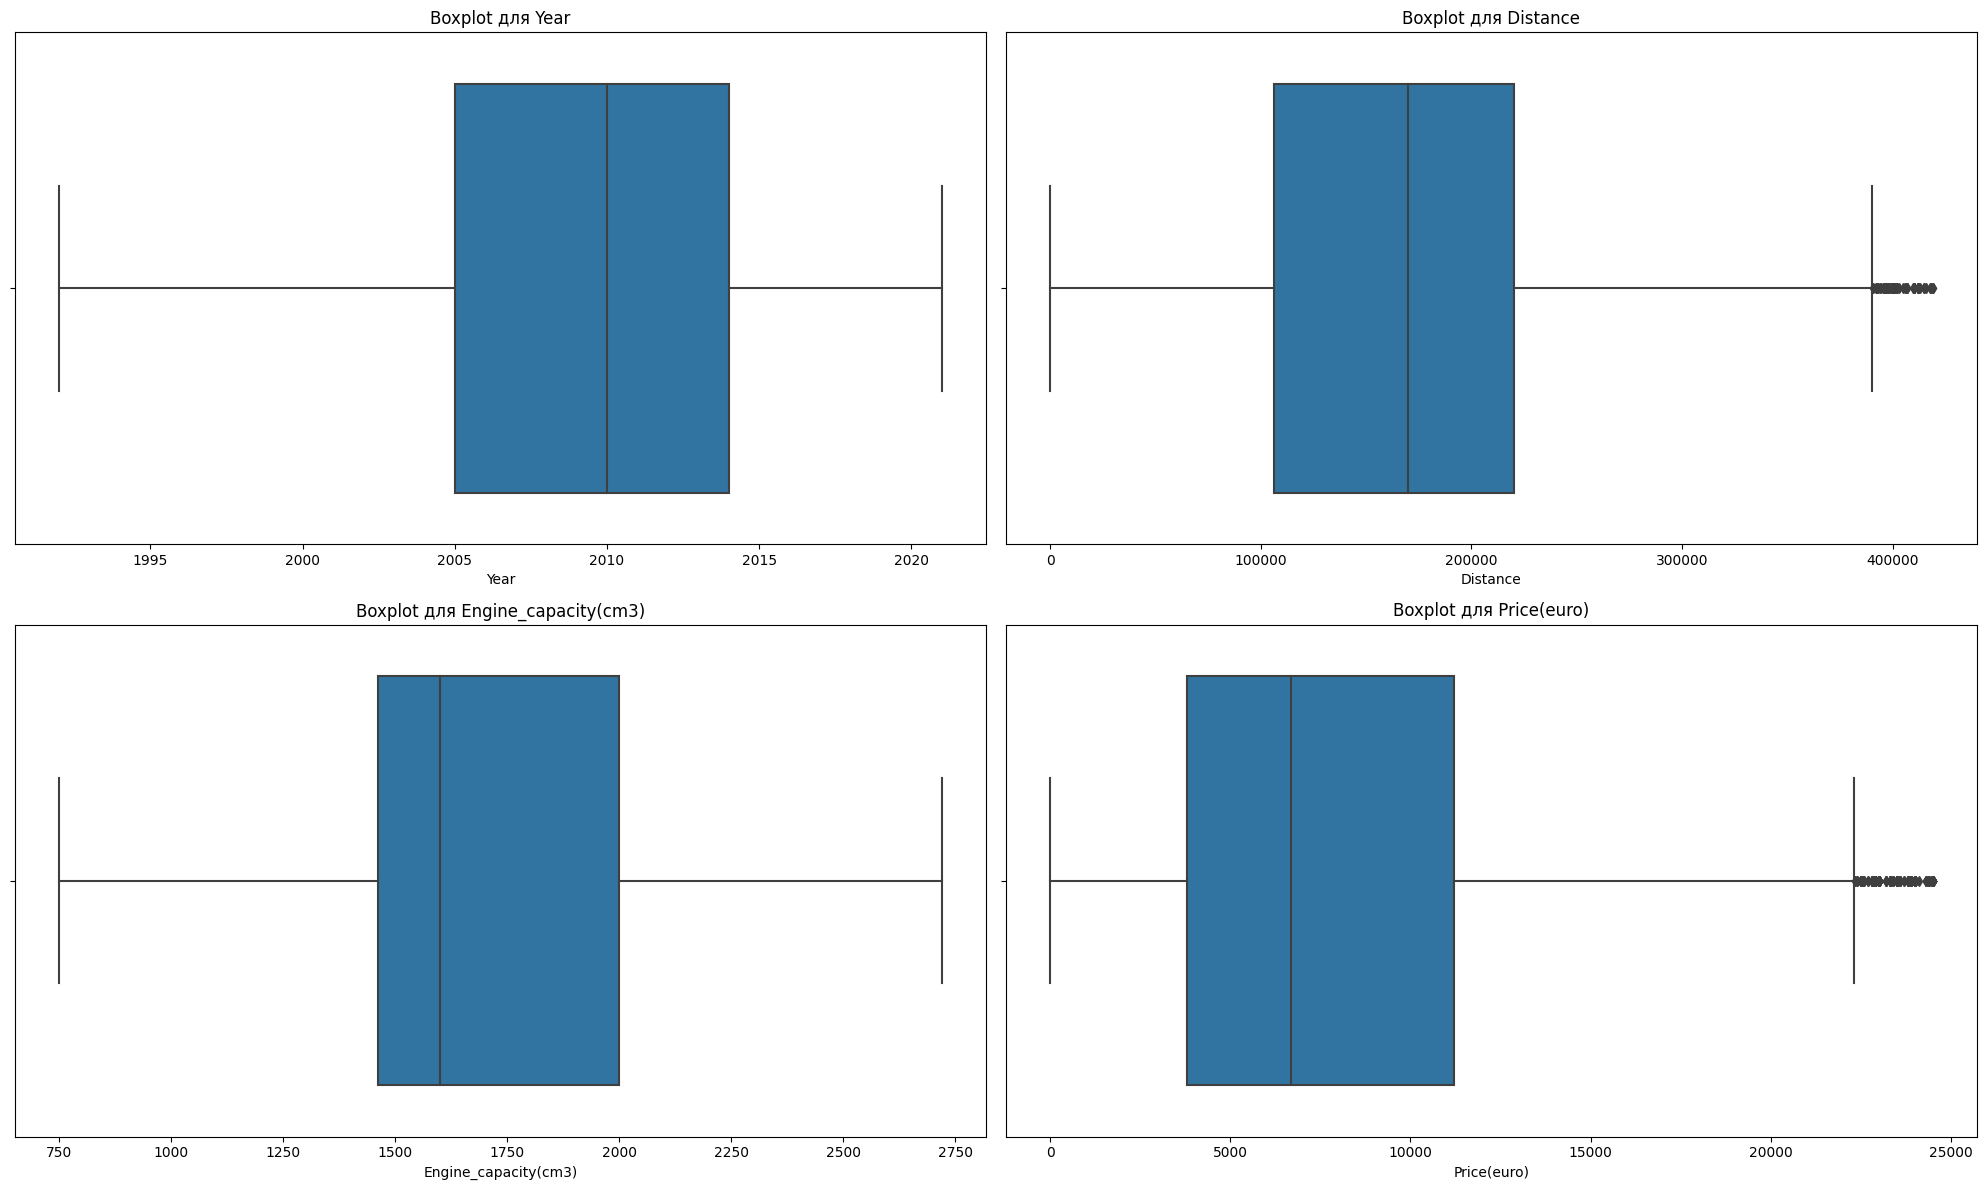

In [ ]:
# Визуализация выбросов с помощью boxplots

plt.figure(figsize=(20, 12))

for idx, col in enumerate(['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)'], start=1):
    plt.subplot(2, 2, idx)
    sns.boxplot(x=cleaned_data[col])
    plt.title(f'Boxplot для {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


**Выделение целевой переменной и предикторов**

In [ ]:
cleaned_data.head()
cleaned_data.to_csv (r'cleaned_cars.csv', index= False )


In [ ]:
# Создание X и y на основе очищенного датасета
y = cleaned_data["Price(euro)"]
X = cleaned_data.drop(["Price(euro)", 'Make', 'Model', 'Style'], axis=1)

# Замена значений в столбце Transmission
X['Transmission'] = X['Transmission'].replace({'Automatic': 1, 'Manual': 0})
X['Fuel_type'] = X['Fuel_type'].replace({'Diesel': 1, 'Petrol': 2, 'Metan/Propan': 3, 'Hybrid': 4, 'Plug-in Hybrid': 5, 'Electric': 6})



X.head()  # Вывод первых строк обновленного набора признаков





,Year,Distance,Engine_capacity(cm3),Fuel_type,Transmission
0,2011.0,195000.0,1800.0,4,1
1,2014.0,135000.0,1500.0,1,0
2,1998.0,1.0,1400.0,2,0
3,2012.0,110000.0,1500.0,1,0
4,2006.0,200000.0,1600.0,3,0


In [ ]:
y

0        7750.0
1        8550.0
2        2200.0
3        6550.0
4        4100.0
          ...  
41001    4400.0
41002    7000.0
41003    4500.0
41005    4000.0
41006    4000.0
Name: Price(euro), Length: 32791, dtype: float64

**Разделение данных на обучающую и тестовую выборки**

Итак, данные предобработаны, целевой признак выделен, имеются обучающая и тестовая выборка. Мы готовы приступить к обучению.

Реализуем для начала простую регрессию

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

simple_X = cleaned_data[['Year']]
simple_y = cleaned_data['Price(euro)']


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(simple_X, simple_y, test_size=0.2, random_state=42)


# Обучение модели
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = regressor.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(13148277.32648257, 0.5078512817250964)

Вот результаты простой линейной регрессии:

    Среднеквадратическая ошибка (MSE): 13148277.32648257
    Коэффициент детерминации R^2: 0.5078512817250964

Коэффициент детерминации R^2 указывает на то, что примерно 51% вариации цены можно объяснить годом выпуска автомобиля.

**другой признак**

**Линейная регрессия (Linear Regression). Постановка задачи.**

Теперь проведем ту же процедуру, но с большим количеством предикторов.

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Обучение модели
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = regressor.predict(X_test)



In [ ]:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_pred, y_pred))}')
print(f'R^2: {regressor.score(X_test, y_test)}')

MAE: 2220.732402074188
MSE: 8560824.329050964
RMSE: 2925.888639208773
MAPE: 0.0
R^2: 0.679562682144448


После того как мы началали давать для обучения больше предикторов, все показатели занчительно выросли. Показатель R^2 = 67%, это значит что успешность предсказания цены автомобиля равна 67%. Также показатель MSE уменьшился, что значит количество ошибок сократилось.

Теперь попробуем применить регуляризации.

In [ ]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score

#L1
# Создание и обучение Lasso модели
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Предсказание с использованием Lasso модели
y_predict_lasso = lasso.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_predict_lasso)}')
print(f'MSE: {mean_squared_error(y_test, y_predict_lasso)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_predict_lasso))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_predict_lasso, y_predict_lasso))}')
print(f'R^2: {lasso.score(X_test, y_test)}')
print('--------------')


#L2
# Создание и обучение Ridge модели
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

# Предсказание с использованием Ridge модели
y_predict_ridge = ridge.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_predict_ridge)}')
print(f'MSE: {mean_squared_error(y_test, y_predict_ridge)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_predict_ridge))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_predict_ridge, y_predict_ridge))}')
print(f'R^2: {ridge.score(X_test, y_test)}')



MAE: 2220.7305208504335
MSE: 8560827.443072785
RMSE: 2925.8891713584753
MAPE: 0.0
R^2: 0.6795625655845512
--------------
MAE: 2220.73224132172
MSE: 8560824.153145764
RMSE: 2925.88860914864
MAPE: 0.0
R^2: 0.6795626887286961


После применения метода регуляризации, основные показатели сильно не изменились, идем дальше.

Попробуем выполнить подбор параметра с помощью GridSearchCV, RandomizedSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np

param_grid_ridge = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}


ridge_optimal = GridSearchCV(Ridge(), param_grid_ridge).fit(X_train, y_train)
# выводим оптимальные значения параметров


ridge_optimal_rand = RandomizedSearchCV(Ridge(), param_grid_ridge).fit(X_train, y_train)
# выводим оптимальные значения параметров

print(f"RIDGE\nGrindSearch ---> {ridge_optimal.best_params_}\nRandomizedSearch ---> {ridge_optimal_rand.best_params_['alpha']}")



ridge_optimal = GridSearchCV(Lasso(), param_grid_ridge).fit(X_train, y_train)
# выводим оптимальные значения параметров


ridge_optimal_rand = RandomizedSearchCV(Lasso(), param_grid_ridge).fit(X_train, y_train)
# выводим оптимальные значения параметров


print(f"LASSO\nGrindSearch ---> {ridge_optimal.best_params_}\nRandomizedSearch ---> {ridge_optimal_rand.best_params_['alpha']}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RIDGE
GrindSearch ---> {'alpha': 1}
RandomizedSearch ---> 1


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


LASSO
GrindSearch ---> {'alpha': 0.1}
RandomizedSearch ---> 0.1


Мы нашли самые подходящие гиперпараметры для каждого метода. Теперь применим их на всех предыдущих методах.

In [ ]:
#L1
# Создание и обучение Lasso модели
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Предсказание с использованием Lasso модели
y_predict_lasso = lasso.predict(X_test)


print('LASSO WITH NEW VALUE')
print(f'MAE: {mean_absolute_error(y_test, y_predict_lasso)}')
print(f'MSE: {mean_squared_error(y_test, y_predict_lasso)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_predict_lasso))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_predict_lasso, y_predict_lasso))}')
print(f'R^2: {lasso.score(X_test, y_test)}')
print('--------------')


#L2
# Создание и обучение Ridge модели
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

# Предсказание с использованием Ridge модели
y_predict_ridge = ridge.predict(X_test)


print('RIDGE WITH NEW VALUE')
print(f'MAE: {mean_absolute_error(y_test, y_predict_ridge)}')
print(f'MSE: {mean_squared_error(y_test, y_predict_ridge)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_predict_ridge))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_predict_ridge, y_predict_ridge))}')
print(f'R^2: {ridge.score(X_test, y_test)}')


LASSO WITH NEW VALUE
MAE: 2220.7305208504335
MSE: 8560827.443072785
RMSE: 2925.8891713584753
MAPE: 0.0
R^2: 0.6795625655845512
--------------
RIDGE WITH NEW VALUE
MAE: 2220.730794876865
MSE: 8560822.616698295
RMSE: 2925.8883465878007
MAPE: 0.0
R^2: 0.6795627462389411


Основные параметры не поменялись.

Применим метод полиномиальной регрессии.

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

#применение с методом Ridge
pipeline = make_pipeline(PolynomialFeatures(2), Ridge())
pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train, y_train)
print('Model determination: ', round(score, 2))

print (f'MSE: {round (mean_squared_error(y_test, pred), 2)}')
print (f'RMSE: {(round (sqrt (mean_squared_error(y_test, pred)),2))}')
print (f'MAPE: {round (sqrt (mean_absolute_percentage_error(y_test, pred)),2)}')
print(f'R^2: {round (pipeline.score (X_test, y_test), 2)}')

Mean error: 2.41e+03 (32.2%)
Model determination:  0.77
MSE: 5803490.83
RMSE: 2409.04
MAPE: 0.63
R^2: 0.78


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.41171e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Метод полиномиальной регрессии показал на данный момент лучшие результаты.
Показатель R^2 = 78%, что на 10% выше предыдущего рекорда, также показатель MSE уменьшился, следовательно количество ошибок в прогнозах сократилось.

In [ ]:
#применение с методом Lasso
pipeline = make_pipeline(PolynomialFeatures(2), Lasso())
pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train, y_train)
print('Model determination: ', round(score, 2))

print (f'MSE: {round (mean_squared_error(y_test, pred), 2)}')
print (f'RMSE: {(round (sqrt (mean_squared_error(y_test, pred)),2))}')
print (f'MAPE: {round (sqrt (mean_absolute_percentage_error(y_test, pred)),2)}')
print(f'R^2: {round (pipeline.score (X_test, y_test), 2)}')

Mean error: 2.87e+03 (38.3%)
Model determination:  0.67
MSE: 8233048.05
RMSE: 2869.33
MAPE: 0.74
R^2: 0.69


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+11, tolerance: 7.146e+07
  model = cd_fast.enet_coordinate_descent(


In [ ]:
#применение с методом Ridge
pipeline = make_pipeline(PolynomialFeatures(2), Ridge())
pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train, y_train)
print('Model determination: ', round(score, 2))

print (f'MSE: {round (mean_squared_error(y_test, pred), 2)}')
print (f'RMSE: {(round (sqrt (mean_squared_error(y_test, pred)),2))}')
print (f'MAPE: {round (sqrt (mean_absolute_percentage_error(y_test, pred)),2)}')
print(f'R^2: {round (pipeline.score (X_test, y_test), 2)}')

Mean error: 2.41e+03 (32.2%)
Model determination:  0.77
MSE: 5803490.83
RMSE: 2409.04
MAPE: 0.63
R^2: 0.78


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.41171e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Вместе с методом Lasso полиномиальная регрессия сработала неплохо, но есть результаты выше.
В то время, как вместе с Ridge показатели схожи с рекордными.

# Итог

Как итог, имеем двух финалистов с самыми высокими показателями точности предсказаний, а именно **метод Полиномиальной регрессии** и этот же метод в совокупности с **методом Ridge**.

Ниже будут приведены лучшие показатели:

```
Mean error: 2.41e+03 (32.2%)
Model determination:  0.77
MSE: 5803490.83
RMSE: 2409.04
MAPE: 0.63
R^2: 0.78
```